R environment

In [ ]:
library(tidyverse)
library(Seurat)
library(stringr)
library(tibble)
library(data.table)
library(DoubletFinder)
library(KernSmooth)
library(Matrix)
library(dplyr)
library(future)
library(cluster)
library(HGNChelper)
library(parallel)
source("helper_functions_v1.R") #TODOlibrary(future)
set.seed(1)
plan("multiprocess", workers = 8)
options(future.globals.maxSize = 1000 * 1024^6)

Filtering criteria: <br>
- min.cells = 1000 per study <br>
- min.gene = 500 <br>
- min.umi = 1000 <br>
- max.MT = 30 <br>

In [ ]:
path.dir = '/hpc/pmc_stunnenberg/cruiz/scRNA/markers-and-databases/GBM_public-data/'

Clinical data abbreviations

__WT__=wild type  <br>
__NT__=not tested  <br>
__M__=promoter methylated  <br> 
__NM__=promoter not methylated

### Chen2021
Raw counts matrices <br>
Microwell-seq (custom platform) <br>

In [ ]:
tidy.tables <- function(filename) {
    dat=data.table::fread(filename)
    dat <- as.data.frame(dat[,-1])
    dat <- dat[!duplicated(dat$Gene), ]
    rownames(dat) <- NULL
    dat <- column_to_rownames(dat, 'Gene')
    dat <- as.matrix(dat)
}

In [ ]:
tmp <- list.files(paste0(path.dir, "Chen2021"),
               pattern = "*.txt.gz", 
               full.names = T)
myfiles = lapply(tmp, tidy.tables)

In [ ]:
labels <- str_sub(tmp, start = 92, end=str_locate(tmp,"counts")[,1]-2)
names(myfiles) <- labels

In [ ]:
Chen2021 <- list()
for (i in 1:length(myfiles)) {
    seu_obj <- CreateSeuratObject(myfiles[[i]], min.features = 500, min.cells = 5,
                                  project = names(myfiles[i]))
    Chen2021 <- append(Chen2021, seu_obj)
}

In [ ]:
Chen2021_final <- merge(Chen2021[[1]], y = unlist(Chen2021[2:length(Chen2021)]), 
             add.cell.ids = labels, project = "Chen2021", merge.data = T)

In [ ]:
Chen2021_final <- PercentageFeatureSet(Chen2021_final, pattern = "^MT-", col.name = "percent.MT")
Chen2021_final <- subset(Chen2021_final, subset = percent.MT < 30 & nCount_RNA > 1000)

In [ ]:
Chen2021_clinical <- subset(readxl::read_excel(paste0(path.dir, 'Chen2021/13073_2021_906_MOESM1_ESM.xlsx'), sheet = "New Data"),
                            select = c('Patient','Location','EGFR','TERT'))

In [ ]:
# creating cell metadata (is not available in the paper)
Chen2021_meta <- data.frame(Cell = colnames(Chen2021_final),
           Patient = str_sub(colnames(Chen2021_final), start = 0, end=str_locate(colnames(Chen2021_final),"_")[,1]-1),
           check.names = FALSE
          )

In [ ]:
Chen2021_meta <- merge(Chen2021_meta, Chen2021_clinical, by= "Patient")
Chen2021_meta$Platform <- 'Microwell-seq'
Chen2021_meta$Method <- 'cell'
Chen2021_meta$Celltype <- 'NA' 

In [ ]:
Chen2021_matrix <- GetAssayData(Chen2021_final, slot = 'counts')[,colnames(Chen2021_final) %in% Chen2021_meta$Cell]

In [ ]:
gene.names <- checkGeneSymbols(rownames(Chen2021_matrix), unmapped.as.na=FALSE)
rownames(Chen2021_matrix) <- make.unique(gene.names$Suggested.Symbol)

### Friedrich2021
Seurat object <br>
mCEL-seq2 <br>

In [ ]:
load(paste0(path.dir, 'Friedrich2021/GSE166418_seurat-integration-wt-rh-gbm-final.RData'))

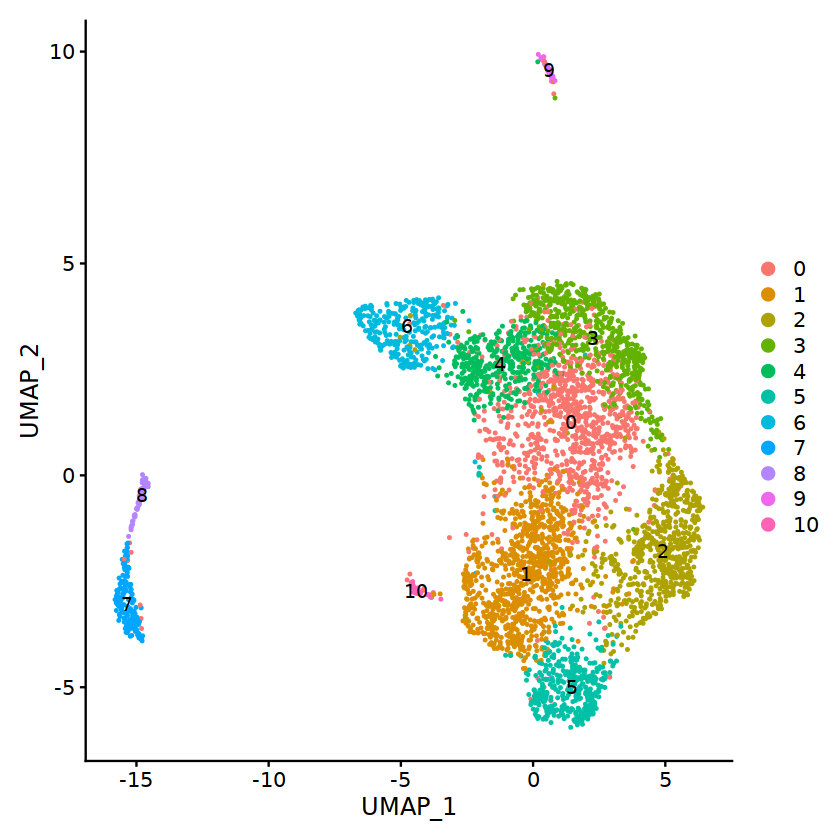

In [ ]:
DimPlot(all, label = TRUE)

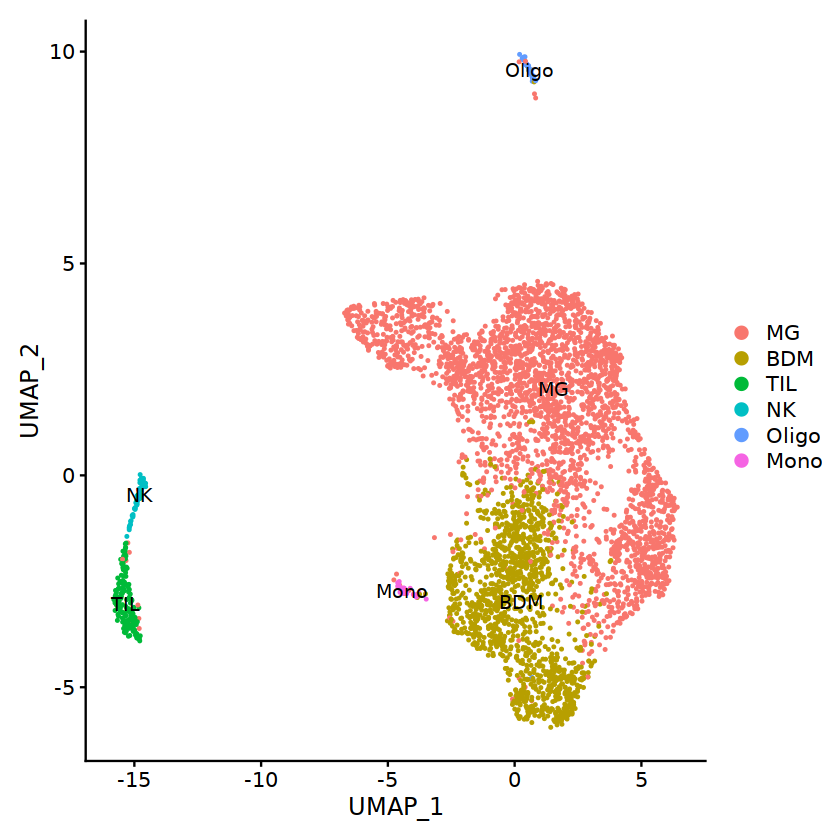

In [ ]:
# based on Figure 1c (https://doi.org/10.1038/s43018-021-00201-z)
all <- RenameIdents(all, `0` = "MG",
                    `1` = "BDM",
                    `2` = "MG", 
                    `3` = "MG", 
                    `4` = "MG", 
                    `5` = "BDM", 
                    `6` = "MG", 
                    `7` = "TIL", 
                    `8` = "NK", 
                    `9` = "Oligo",
                    `10` = "Mono")
DimPlot(all, label = TRUE)

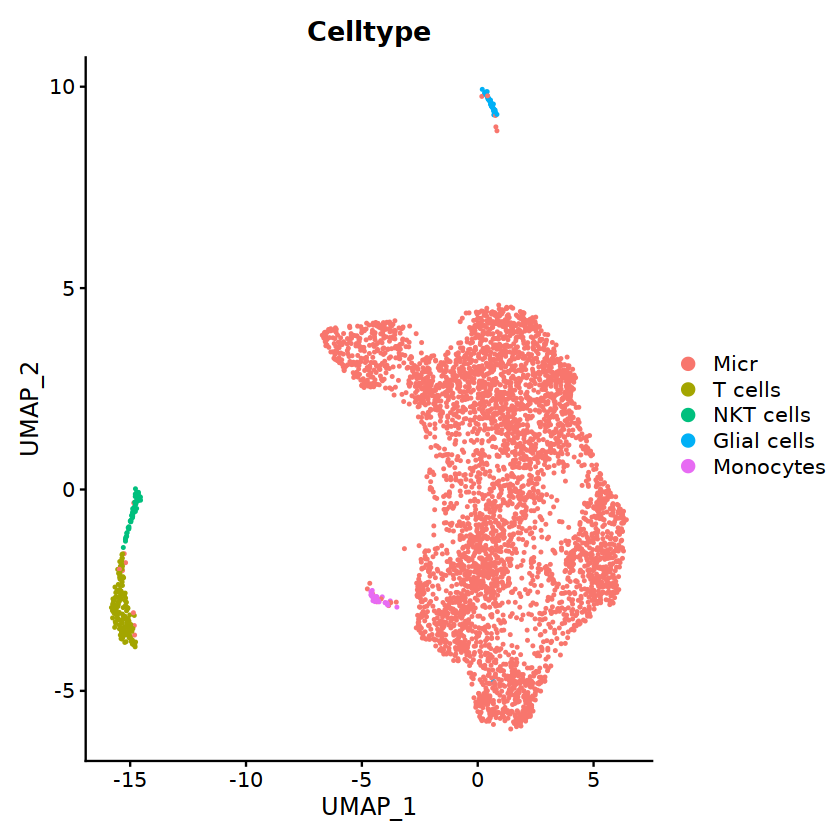

In [ ]:
DimPlot(all, group.by = 'Celltype')

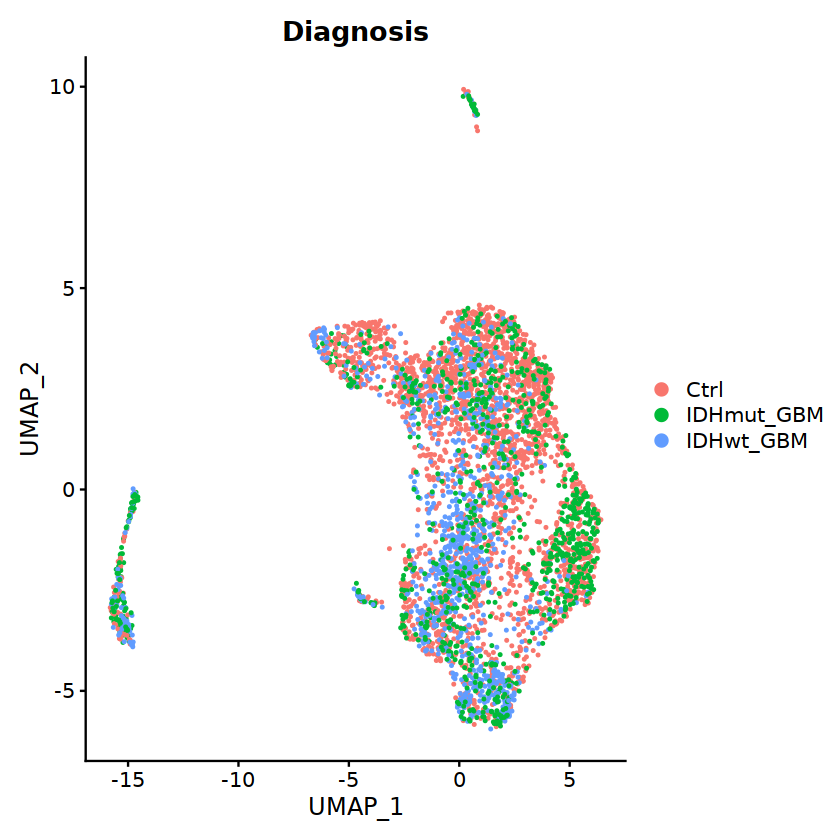

In [ ]:
DimPlot(all, group.by = 'Diagnosis')

In [ ]:
subset_all <- subset(all, subset = Diagnosis == 'IDHwt_GBM')

In [ ]:
Friedrich2021_meta <- subset_all@meta.data %>% rownames_to_column('Cell') %>%
                        select(Cell, Diagnosis, Celltype, Age, Localization, Gender, ID) 
Friedrich2021_meta$Platform <- 'mCEL-seq2'
Friedrich2021_meta$Method <- 'cell'
colnames(Friedrich2021_meta)[which(names(Friedrich2021_meta) == "ID")] <- "Patient"

In [ ]:
Friedrich2021_matrix <- GetAssayData(subset_all, slot = 'counts')

In [ ]:
gene.names <- checkGeneSymbols(rownames(Friedrich2021_matrix), unmapped.as.na=FALSE)
rownames(Friedrich2021_matrix) <- make.unique(gene.names$Suggested.Symbol)

### Xie2021
Raw matrices <br>
10x Genomics <br>

In [ ]:
tmp <- list.files(path = paste0(path.dir, "Xie2021"), pattern = "^R",
               full.names = T)

In [ ]:
labels <- c('control1', 'tumour1', 'control2','tumour2',
           'control3', 'tumour3', 'control4','tumour4')
names(tmp) <- labels

In [ ]:
Xie2021 <- list()
for (i in 1:length(tmp)) {
    seu_obj.data <- Read10X(data.dir = tmp[[i]])
    seu_obj <- CreateSeuratObject(seu_obj.data, min.features = 0, min.cells = 5, 
                                  project = names(tmp[i]))
    Xie2021 <- append(Xie2021, seu_obj)
}

In [ ]:
Xie2021_final <- merge(Xie2021[[1]], y = unlist(Xie2021[2:length(Xie2021)]), 
              add.cell.ids = labels, project = "Xie2021", merge.data = T)

In [ ]:
Xie2021_final <- subset(Xie2021_final, subset = percent.MT < 30 & nCount_RNA > 1000 & nFeature_RNA > 500)

In [ ]:
Xie2021_meta <- readxl::read_excel(paste0(path.dir, 'Xie2021/Fig1_all_cell_annoation_info.xlsx'))
colnames(Xie2021_meta) <- c('Cell', 'Celltype')
Xie2021_meta$Platform <- '10x_v3'
Xie2021_meta$Method <- 'cell'
Xie2021_meta$Cell <- paste0(Xie2021_meta$Cell, '-1')

In [ ]:
Xie2021_final <- subset(Xie2021_final, cells = Xie2021_meta$Cell)

In [ ]:
tmp_meta <- FetchData(Xie2021_final, 'orig.ident') %>% rownames_to_column('Cell')
tmp_meta$Tissue <- tmp_meta$orig.ident
Xie2021_meta <- merge(Xie2021_meta, tmp_meta, by= "Cell")
colnames(Xie2021_meta)[which(names(Xie2021_meta) == "orig.ident")] <- "Sample"

In [ ]:
Xie2021_meta <- Xie2021_meta %>%
  separate(Tissue, 
           into = c("Tissue", "Patient"), 
           sep = "(?<=[A-Za-z])(?=[0-9])"
           )
Xie2021_meta$Patient <- paste0('Patient_', Xie2021_meta$Patient)

In [ ]:
Xie2021_clinical <- subset(readxl::read_excel(paste0(path.dir, 'Xie2021/Xie2021.xlsx'),
                                              sheet = "Seurat"))

In [ ]:
Xie2021_meta <- merge(Xie2021_meta, Xie2021_clinical, by= "Patient")

In [ ]:
Xie2021_matrix <- GetAssayData(Xie2021_final, slot = 'counts')[,colnames(Xie2021_final) %in% Xie2021_meta$Cell]

In [ ]:
gene.names <- checkGeneSymbols(rownames(Xie2021_matrix), unmapped.as.na=FALSE)
rownames(Xie2021_matrix) <- make.unique(gene.names$Suggested.Symbol)

### Abdelfattah2022
Raw matrices <br>
10x Genomics <br>

In [ ]:
tmp <- list.files(path = paste0(path.dir, "Abdelfattah2022"), 
               full.names = T)

In [ ]:
labels <- str_sub(tmp, start = 88) 
names(tmp) <- labels

In [ ]:
Abdelfattah2022 <- list()
for (i in 1:length(tmp)) {
    seu_obj.data <- Read10X(data.dir = tmp[[i]])
    seu_obj <- CreateSeuratObject(seu_obj.data, min.features = 200, min.cells = 5, 
                                  project = names(tmp[i]))
    Abdelfattah2022 <- append(Abdelfattah2022, seu_obj)
}

In [ ]:
# preprocess each dataset individually
Abdelfattah2022 <- lapply(Abdelfattah2022, seuPreProcess)

In [ ]:
# https://github.com/mckellardw/scMuscle/blob/main/R_scripts/scMuscle_github_v1.R

bcmvn <- list()
pK <- list()
homotypic.prop <- list()
nExp_poi <- list()
nExp_poi.adj <- list()

# Estimated Doublet Rate for each dataset
edr <- estimateDoubletRate.DWM(seur.list = Abdelfattah2022)/100 #use your own known EDR here

for(i in 1:length(Abdelfattah2022)){
  cat(' ############################################\n',
      '### DoubletFinder for dataset number ', i, '###\n',
      '############################################\n')
  
  ## pK Identification (no ground-truth)
  bcmvn[[i]]<- paramSweep_v3(
    seu=Abdelfattah2022[[i]],
    PCs = 1:Abdelfattah2022[[i]]@reductions$umap_RNA@misc$n.pcs.used, 
    num.cores = 8
  ) %>% summarizeSweep(
    GT = FALSE
  ) %>% find.pK() 
  
  # Pull out max of bcmvn
  pK[[i]] <- as.numeric(as.character(bcmvn[[i]]$pK[bcmvn[[i]]$BCmetric==max(bcmvn[[i]]$BCmetric)])) # ugly, but functional...
  
  ## Homotypic Doublet Proportion Estimate
  homotypic.prop[[i]] <- modelHomotypic(Abdelfattah2022[[i]]$seurat_clusters) 
  
  nExp_poi[[i]] <- round(edr[[i]]*length(colnames(Abdelfattah2022[[i]])))  
  nExp_poi.adj[[i]] <- round(nExp_poi[[i]]*(1-homotypic.prop[[i]]))
}

In [ ]:
# Run DoubletFinder
for(i in 1:length(Abdelfattah2022)){
  Abdelfattah2022[[i]] <- 
    doubletFinder_V3.DWM_v2( # just changed it so the output metadata column name is customizable
      seu=Abdelfattah2022[[i]], 
      PCs = 1:Abdelfattah2022[[i]]@reductions$umap_RNA@misc$n.pcs.used, 
      pN = 0.25, #default value
      pK= pK[[i]], 
      nExp = nExp_poi.adj[[i]],  
      reuse.pANN = F, 
      classification.name='DF.individual', 
      pANN.name='DF.pANN.individual'
    )
}

In [ ]:
Abdelfattah2022_final <- merge(Abdelfattah2022[[1]], y = unlist(Abdelfattah2022[2:length(Abdelfattah2022)]), 
              add.cell.ids = labels, project = "Abdelfattah2022", merge.data = T)

In [ ]:
Abdelfattah2022_final <- PercentageFeatureSet(Abdelfattah2022_final, pattern = "^MT-", col.name = "percent.MT")
Abdelfattah2022_final <- subset(Abdelfattah2022_final, subset = percent.MT < 30 & nCount_RNA > 1000 & nFeature_RNA > 500)

In [ ]:
# filter doublets
Abdelfattah2022_final <- subset(Abdelfattah2022_final, subset = DF.individual == 'Singlet')

In [ ]:
Abdelfattah2022_meta <- FetchData(Abdelfattah2022_final, 'orig.ident') %>% rownames_to_column('Cell')
Abdelfattah2022_meta$Platform <- '10x_v3'
Abdelfattah2022_meta$Method <- 'cell'
colnames(Abdelfattah2022_meta)[which(names(Abdelfattah2022_meta) == "orig.ident")] <- "Sample"

In [ ]:
Abdelfattah2022_meta$Patient <- sub('^([^-]+-[^-]+).*', '\\1', Abdelfattah2022_meta$Sample)

In [ ]:
Abdelfattah2022_clinical <- subset(readxl::read_excel(paste0(path.dir, 'Abdelfattah2022/Abdelfattah2022.xlsx'),
                                              sheet = "Seurat"))

In [ ]:
Abdelfattah2022_meta <- merge(Abdelfattah2022_meta, Abdelfattah2022_clinical, by= "Patient")

In [ ]:
Abdelfattah2022_matrix <- GetAssayData(Abdelfattah2022_final,  slot = 'counts')[,colnames(Abdelfattah2022_final) %in% Abdelfattah2022_meta$Cell]

In [ ]:
gene.names <- checkGeneSymbols(rownames(Abdelfattah2022_matrix), unmapped.as.na=FALSE)
rownames(Abdelfattah2022_matrix) <- make.unique(gene.names$Suggested.Symbol)

### Lee2021
Seurat object <br>
10x Genomics <br>

In [ ]:
Lee2021 <- readRDS(paste0(path.dir, 'Lee2021/GSE154795_GBM.AllCell.Integrated.Scaled.ClusterRes.0.1.rds'))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



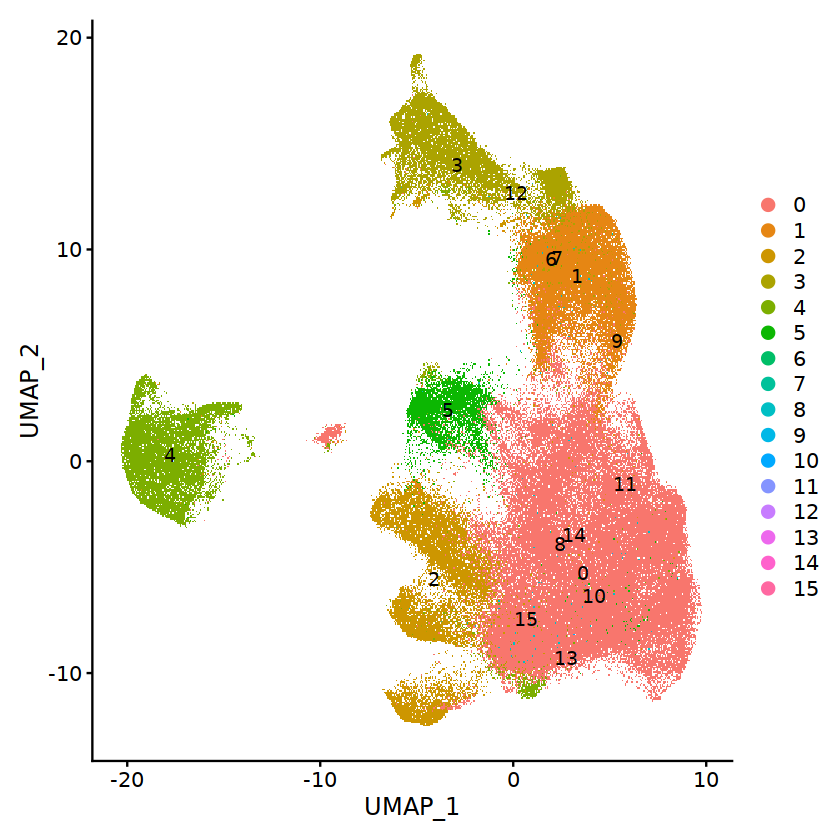

In [ ]:
DimPlot(Lee2021, label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



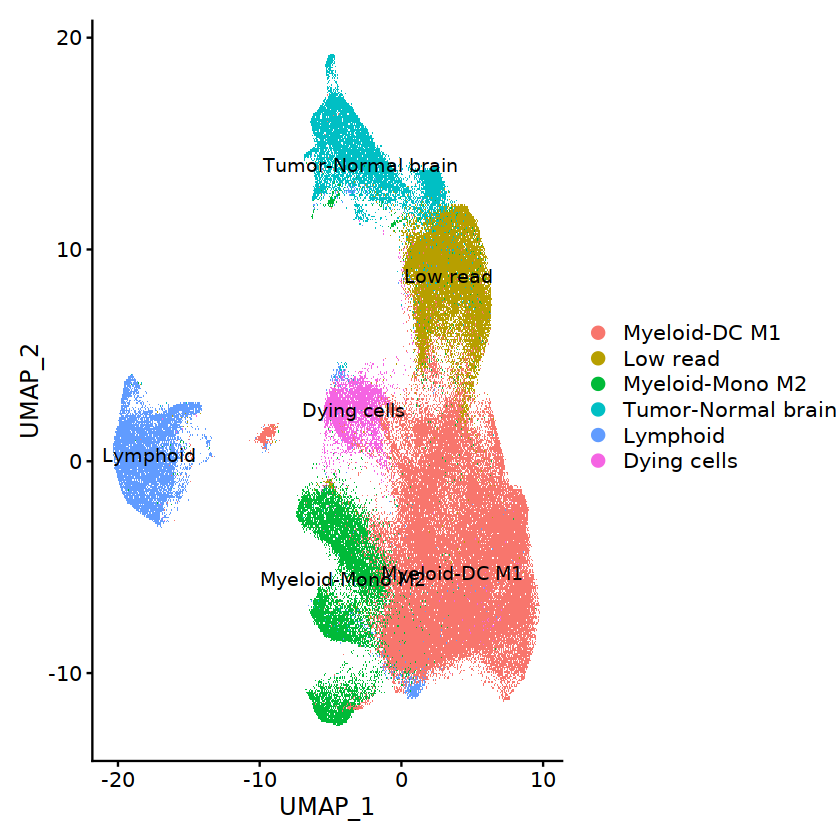

In [ ]:
# original annotation was not in the Seurat object. Annotation was given manually by using Figure 1e as reference (https://doi.org/10.1038/s41467-021-26940-2)

Lee2021 <- RenameIdents(Lee2021, `0` = "Myeloid-DC M1",
                    `1` = "Low read",
                    `2` = "Myeloid-Mono M2", 
                    `3` = "Tumor-Normal brain", 
                    `4` = "Lymphoid", 
                    `5` = "Dying cells", 
                    `6` = "Low read", 
                    `7` = "Low read", 
                    `8` = "Myeloid-DC M1", 
                    `9` = "Low read",
                    `10` = "Myeloid-DC M1",
                    `11` = "Myeloid-DC M1", 
                    `12` = "Tumor-Normal brain", 
                    `13` = "Myeloid-DC M1", 
                    `14` = "Myeloid-DC M1",
                    `15` = "Myeloid-DC M1"
                        )

DimPlot(Lee2021, label = TRUE)

In [ ]:
subset_Lee2021 <- subset(Lee2021, subset = IDH_status == 'WT')
subset_Lee2021 <- subset(subset_Lee2021, subset = percent.MT < 30 & nCount_RNA > 1000 & nFeature_RNA > 500)

In [ ]:
Lee2021_meta <- subset_Lee2021@meta.data %>% rownames_to_column('Cell') %>%
                        select(Cell, ID, condition, MGMT) 
Lee2021_meta$Platform <- '10x_v3'
Lee2021_meta$Method <- 'cell'
colnames(Lee2021_meta)[which(names(Lee2021_meta) == "ID")] <- "Patient"
Lee2021_meta$Cell <- paste0('Lee2021_', Lee2021_meta$Cell)

In [ ]:
DefaultAssay(subset_Lee2021) <- 'RNA'
Lee2021_matrix <- GetAssayData(subset_Lee2021, slot = 'counts') %>% `colnames<-`(Lee2021_meta$Cell)

In [ ]:
gene.names <- checkGeneSymbols(rownames(Lee2021_matrix), unmapped.as.na=FALSE)
rownames(Lee2021_matrix) <- make.unique(gene.names$Suggested.Symbol)

### Ravi2022
Seurat object <br>
10x Genomics <br>

In [ ]:
Ravi2022 <- readRDS(paste0(path.dir, 'Ravi2022_I/seurat.obj_MNN_ref.RDS'))

In [ ]:
subset_Ravi2022 <- subset(Ravi2022, subset = sample != 'X185') # it is not IDHwt
subset_Ravi2022 <- subset(subset_Ravi2022, subset = percent.MT < 30 & nCount_RNA > 1000 & nFeature_RNA > 500)

In [ ]:
Ravi2022_meta <- subset_Ravi2022@meta.data %>% rownames_to_column('Cell') %>%
                        select(Cell, sample, predicted.celltype.l2) 
Ravi2022_meta$Platform <- '10x_v3'
Ravi2022_meta$Method <- 'cell'
colnames(Ravi2022_meta)[which(names(Ravi2022_meta) == "sample")] <- "Patient"
colnames(Ravi2022_meta)[which(names(Ravi2022_meta) == 
                              "predicted.celltype.l2")] <- "Celltype"
Ravi2022_meta$Cell <- paste0('Ravi2022_', Ravi2022_meta$Cell)

In [ ]:
Ravi2022_clinical <- readxl::read_excel(paste0(path.dir, 'Ravi2022_I/Ravi2022.xlsx'))

In [ ]:
Ravi2022_meta <- merge(Ravi2022_meta, Ravi2022_clinical, by= "Patient")

In [ ]:
DefaultAssay(subset_Ravi2022) <- 'RNA'
Ravi2022_matrix <- GetAssayData(subset_Ravi2022, slot = 'counts') %>% `colnames<-`(Ravi2022_meta$Cell)

In [ ]:
gene.names <- checkGeneSymbols(rownames(Ravi2022_matrix), unmapped.as.na=FALSE)
rownames(Ravi2022_matrix) <- make.unique(gene.names$Suggested.Symbol)

### LeBlanc2022
Raw counts matrices <br>
10X Genomics <br>

In [ ]:
tmp <- Read10X(paste0(path.dir, 'LeBlanc2022/raw_matrix'))

LeBlanc2022 <- CreateSeuratObject(tmp)

In [ ]:
LeBlanc2022_meta <- fread(paste0(path.dir, 'LeBlanc2022/GSE173278_scRNAseq_all_cells_metadata.csv')) %>%
filter(source == 'tis') %>% select(-c(reg_stg, source))
colnames(LeBlanc2022_meta) <- c('Cell', 'Sample', 'Patient')
LeBlanc2022_meta$Platform <- '10x_v3.1'
LeBlanc2022_meta$Method <- 'cell'

In [ ]:
LeBlanc2022_clinical <- readxl::read_excel(paste0(path.dir, 'LeBlanc2022/LeBlanc2022.xlsx'), 
                                           sheet = 'Seurat')

In [ ]:
LeBlanc2022_meta <- merge(LeBlanc2022_meta, LeBlanc2022_clinical, by= "Patient")

In [ ]:
LeBlanc2022_final <- subset(LeBlanc2022, cells = LeBlanc2022_meta$Cell)
LeBlanc2022_final <- subset(LeBlanc2022_final, subset = percent.MT < 30 & nCount_RNA > 1000 & nFeature_RNA > 500)

In [ ]:
LeBlanc2022_matrix <- GetAssayData(LeBlanc2022_final, slot = 'counts')[,colnames(LeBlanc2022_final) %in% LeBlanc2022_meta$Cell]

In [ ]:
gene.names <- checkGeneSymbols(rownames(LeBlanc2022_matrix), unmapped.as.na=FALSE)
rownames(LeBlanc2022_matrix) <- make.unique(gene.names$Suggested.Symbol)

## Merging metadata

In [ ]:
#merge cell data (inner join) - organized by dataset with the higer number of detected genes (the order does not matter)
common_names <- intersect(rownames(Chen2021_matrix), rownames(Friedrich2021_matrix))
common_names <- intersect(rownames(Xie2021_matrix), common_names)
common_names <- intersect(rownames(Abdelfattah2022_matrix), common_names)
common_names <- intersect(rownames(Lee2021_matrix), common_names)
common_names <- intersect(rownames(Ravi2022_matrix), common_names)
common_names <- intersect(rownames(LeBlanc2022_matrix), common_names)

In [ ]:
cells_all <- cbind(Chen2021_matrix[rownames(Chen2021_matrix) %in% common_names,],
                   Friedrich2021_matrix[rownames(Friedrich2021_matrix) %in% common_names,])                   
cells_all <- cbind(cells_all, Xie2021_matrix[rownames(Xie2021_matrix) %in% common_names,])
cells_all <- cbind(cells_all, Abdelfattah2022_matrix[rownames(Abdelfattah2022_matrix) %in% common_names,])
cells_all <- cbind(cells_all, Lee2021_matrix[rownames(Lee2021_matrix) %in% common_names,])
cells_all <- cbind(cells_all, Ravi2022_matrix[rownames(Ravi2022_matrix) %in% common_names,])
cells_all <- cbind(cells_all, LeBlanc2022_matrix[rownames(LeBlanc2022_matrix) %in% common_names,])

In [ ]:
author <- c(rep('Chen2021', length(colnames(Chen2021_matrix))),
            rep('Friedrich2021', length(colnames(Friedrich2021_matrix))),
            rep('Xie2021', length(colnames(Xie2021_matrix))),
            rep('Abdelfattah2022', length(colnames(Abdelfattah2022_matrix))),
            rep('Lee2021', length(colnames(Lee2021_matrix))),
            rep('Ravi2022', length(colnames(Ravi2022_matrix))),
            rep('LeBlanc2022', length(colnames(LeBlanc2022_matrix)))
             )

In [ ]:
meta <- data.frame(cell = colnames(cells_all), author = author)

In [ ]:
meta_datasets <- list(Chen2021_meta, Friedrich2021_meta, 
                      as.data.frame(Xie2021_meta), as.data.frame(Abdelfattah2022_meta),
                     as.data.frame(Lee2021_meta),as.data.frame(Ravi2022_meta),
                     as.data.frame(LeBlanc2022_meta)) %>% purrr::reduce(full_join)

In [ ]:
colnames(meta_datasets) <- tolower(colnames(meta_datasets))
names(meta_datasets)[names(meta_datasets) == 'egfr'] <- 'EGFR'
names(meta_datasets)[names(meta_datasets) == 'tert'] <- 'TERT'
names(meta_datasets)[names(meta_datasets) == 'ki_67'] <- 'KI_67'
names(meta_datasets)[names(meta_datasets) == 'mgmt'] <- 'MGMT'

In [ ]:
meta_all <- list(meta, meta_datasets) %>% purrr::reduce(inner_join, by = 'cell') %>% distinct(cell, .keep_all = TRUE) %>% 
            column_to_rownames('cell')

## Output for Seurat

List of individual Seurat files

In [ ]:
gbm_matrix <- list(Chen2021_matrix, Friedrich2021_matrix, Xie2021_matrix, 
                   Abdelfattah2022_matrix, Lee2021_matrix, Ravi2022_matrix,
                  LeBlanc2022_matrix)
studies <- c('Chen2021', 'Friedrich2021', 'Xie2021', 
             'Abdelfattah2022', 'Lee2021', 'Ravi2022',
            'LeBlanc2022')

gbm_all <- list()

for (i in 1:length(gbm_matrix)) {
    seu_obj <- CreateSeuratObject(gbm_matrix[[i]], min.features = 0, min.cells = 0,
                                  project = studies[i])
    gbm_all <- append(gbm_all, seu_obj)
}

In [ ]:
format(object.size(gbm_all), units = "Gb")

In [ ]:
saveRDS(gbm_all, 'data/query_GB_studies.rds')

In [ ]:
saveRDS(meta_all, 'data/query_GB_studies_metadata.rds')

## Output for scArches

In [ ]:
scarches <- merge(gbm_all[[1]], y = unlist(gbm_all[2:length(gbm_all)]), project = "GBM_new_studies", merge.data = T))

In [ ]:
reference <- readRDS('data/core_GBmap.rds')

In [ ]:
# Output a logical vector for every gene on whether the more than zero counts per cell
# Extract counts
counts <- GetAssayData(object = scarches, slot = "counts")

# Sums all TRUE values and returns TRUE if more than 100 TRUE values per gene
keep_genes <- rownames(reference) # subset genes as they should be the same for the training with scArches

# Only keeping those genes expressed in more than 100 cells
filtered_counts <- counts[rownames(counts) %in% keep_genes, ]

# Reassign to filtered Seurat object
filtered_scarches <- CreateSeuratObject(filtered_counts)

In [ ]:
library(DropletUtils)
mtx <- GetAssayData(object = filtered_scarches, slot = "counts") 
write10xCounts( 'data/query_GB_studies.h5',
  mtx,
  barcodes = colnames(mtx),
  gene.id = rownames(mtx),
  gene.symbol = rownames(mtx),
  gene.type = "Gene Expression",
  overwrite = TRUE,
  type = c("HDF5"),
  genome = "unknown",
  version = c("3"),
  chemistry = NULL,
  original.gem.groups = NULL,
  library.ids = NULL)

In [ ]:
write.table(meta_all,
            'data/query_GB_studies_metadata.csv',
           row.names = TRUE, col.names = TRUE, quote = FALSE, sep = ',')

### Second compilation of additional GB datasets

### CPTAC-3 (Wang2021)
Raw matrices <br>
10x Genomics <br>

In [ ]:
tmp <- list.files(path = paste0(path.dir, "CPTAC-3"), 
               full.names = T)

In [ ]:
labels <- str_sub(tmp, start = 80)

In [ ]:
CPTAC_3 <- list()
for (i in 1:length(tmp)) {
    seu_obj.data <- Read10X(data.dir = paste0(tmp[[i]], '/filtered_feature_bc_matrix'))
    seu_obj <- CreateSeuratObject(seu_obj.data, min.features = 200, min.cells = 5, 
                                  project = names(tmp[i]))
    CPTAC_3 <- append(CPTAC_3, seu_obj)
}

In [ ]:
# preprocess each dataset individually
CPTAC_3 <- lapply(CPTAC_3, seuPreProcess)

In [ ]:
# https://github.com/mckellardw/scMuscle/blob/main/R_scripts/scMuscle_github_v1.R

bcmvn <- list()
pK <- list()
homotypic.prop <- list()
nExp_poi <- list()
nExp_poi.adj <- list()

# Estimated Doublet Rate for each dataset
edr <- estimateDoubletRate.DWM(seur.list = CPTAC_3)/100 #use your own known EDR here

for(i in 1:length(CPTAC_3)){
  cat(' ############################################\n',
      '### DoubletFinder for dataset number ', i, '###\n',
      '############################################\n')
  
  ## pK Identification (no ground-truth)
  bcmvn[[i]]<- paramSweep_v3(
    seu=CPTAC_3[[i]],
    PCs = 1:CPTAC_3[[i]]@reductions$umap_RNA@misc$n.pcs.used, 
    num.cores = 8
  ) %>% summarizeSweep(
    GT = FALSE
  ) %>% find.pK() 
  
  # Pull out max of bcmvn
  pK[[i]] <- as.numeric(as.character(bcmvn[[i]]$pK[bcmvn[[i]]$BCmetric==max(bcmvn[[i]]$BCmetric)])) # ugly, but functional...
  
  ## Homotypic Doublet Proportion Estimate
  homotypic.prop[[i]] <- modelHomotypic(CPTAC_3[[i]]$seurat_clusters) 
  
  nExp_poi[[i]] <- round(edr[[i]]*length(colnames(CPTAC_3[[i]])))  
  nExp_poi.adj[[i]] <- round(nExp_poi[[i]]*(1-homotypic.prop[[i]]))
}

In [ ]:
# Run DoubletFinder
for(i in 1:length(CPTAC_3)){
  CPTAC_3[[i]] <- 
    doubletFinder_V3.DWM_v2( # just changed it so the output metadata column name is customizable
      seu=CPTAC_3[[i]], 
      PCs = 1:CPTAC_3[[i]]@reductions$umap_RNA@misc$n.pcs.used, 
      pN = 0.25, #default value
      pK= pK[[i]], 
      nExp = nExp_poi.adj[[i]],  
      reuse.pANN = F, 
      classification.name='DF.individual', 
      pANN.name='DF.pANN.individual'
    )
}

In [ ]:
CPTAC_3_final <- merge(CPTAC_3[[1]], y = unlist(CPTAC_3[2:length(CPTAC_3)]), 
              add.cell.ids = labels, project = "CPTAC_3", merge.data = T)

In [ ]:
CPTAC_3_final <- PercentageFeatureSet(CPTAC_3_final, pattern = "^MT-", col.name = "percent.MT")
CPTAC_3_final <- subset(CPTAC_3_final, subset = percent.MT < 30 & nCount_RNA > 1000 & nFeature_RNA > 500)

In [ ]:
# filter doublets
CPTAC_3_final <- subset(CPTAC_3_final, subset = DF.individual == 'Singlet')

In [ ]:
CPTAC_3_meta <- FetchData(CPTAC_3_final, 'orig.ident') %>% rownames_to_column('Cell')
CPTAC_3_meta$Platform <- '10x_v3'
CPTAC_3_meta$Method <- 'cell'
colnames(CPTAC_3_meta)[which(names(CPTAC_3_meta) == "orig.ident")] <- "Patient"

In [ ]:
CPTAC_3_clinical <- readxl::read_excel(paste0(path.dir, 'CPTAC-3/CPTAC-3_metadata.xlsx'))

In [ ]:
CPTAC_3_meta <- merge(CPTAC_3_meta, CPTAC_3_clinical, by= "Patient")

In [ ]:
CPTAC_3_matrix <- GetAssayData(CPTAC_3_final,  slot = 'counts')[,colnames(CPTAC_3_final) %in% CPTAC_3_meta$Cell]

In [ ]:
gene.names <- checkGeneSymbols(rownames(CPTAC_3_matrix), unmapped.as.na=FALSE)
rownames(CPTAC_3_matrix) <- make.unique(gene.names$Suggested.Symbol)

### Jacob2021
Raw matrix <br>
Drop-seq <br>

In [ ]:
tmp <- as.matrix(fread(paste0(path.dir, 'Jacob2021/GSE141946_scRNAseq.counts.txt')) %>% 
                 column_to_rownames('V1'))

Jacob2021 <- CreateSeuratObject(tmp)

In [ ]:
Jacob2021_meta <- fread(paste0(path.dir, 'Jacob2021/GSE141946_scRNAseq.metadata.csv'),header = TRUE) %>%
                filter(Timepoint == 'Tumor') %>% select(-c(Barcode, Timepoint))
colnames(Jacob2021_meta) <- c('Cell', 'Sample')
Jacob2021_meta$Patient <- Jacob2021_meta$Sample  
Jacob2021_meta$Patient = recode(Jacob2021_meta$Patient,
                                    `8165C` = '8165',
                                       `8165PV` = "8165"
                          )
Jacob2021_meta$Patient <- paste0('UP-', Jacob2021_meta$Patient)
Jacob2021_meta$Sample <- paste0('UP-', Jacob2021_meta$Sample)
Jacob2021_meta$Platform <- 'Drop-seq'
Jacob2021_meta$Method <- 'cell'

In [ ]:
Jacob2021_clinical <- readxl::read_excel(paste0(path.dir, 'Jacob2021/mmc1.xlsx'))
Jacob2021_clinical$KI_67 = recode(Jacob2021_clinical$KI_67,
                                    `0.2` = '20%',
                                       `0.10` = "10%",
                                  `0.25` = "25%"
                          )

In [ ]:
Jacob2021_meta <- merge(Jacob2021_meta, Jacob2021_clinical, by= "Patient")

In [ ]:
Jacob2021_final <- subset(Jacob2021, cells = Jacob2021_meta$Cell)
Jacob2021_final <- subset(Jacob2021_final, subset = percent.MT < 30 & nCount_RNA > 1000 & nFeature_RNA > 500)

In [ ]:
Jacob2021_matrix <- GetAssayData(Jacob2021_final, slot = 'counts')[,colnames(Jacob2021_final) %in% Jacob2021_meta$Cell]

In [ ]:
gene.names <- checkGeneSymbols(rownames(Jacob2021_matrix), unmapped.as.na=FALSE)
rownames(Jacob2021_matrix) <- make.unique(gene.names$Suggested.Symbol)

## Merging metadata

In [ ]:
#merge cell data (inner join) - organized by dataset with the higer number of detected genes (the order does not matter)
common_names <- intersect(rownames(Jacob2021_matrix), rownames(CPTAC_3_matrix))

In [ ]:
cells_all <- cbind(Jacob2021_matrix[rownames(Jacob2021_matrix) %in% common_names,],
                   CPTAC_3_matrix[rownames(CPTAC_3_matrix) %in% common_names,])             

In [ ]:
author <- c(rep('Jacob2021', length(colnames(Jacob2021_matrix))),
            rep('CPTAC-3', length(colnames(CPTAC_3_matrix)))
             )

In [ ]:
meta <- data.frame(cell = colnames(cells_all), author = author)

In [ ]:
# Chen2021_meta <- Chen2021_meta %>% select(PatiwenCell, Platform, Method)
meta_datasets <- list(Jacob2021_meta, CPTAC_3_meta) %>% purrr::reduce(full_join)

In [ ]:
colnames(meta_datasets) <- tolower(colnames(meta_datasets))
names(meta_datasets)[names(meta_datasets) == 'egfr'] <- 'EGFR'
names(meta_datasets)[names(meta_datasets) == 'tert'] <- 'TERT'
names(meta_datasets)[names(meta_datasets) == 'ki_67'] <- 'KI_67'
names(meta_datasets)[names(meta_datasets) == 'mgmt methylation'] <- 'MGMT'

In [ ]:
options(repr.matrix.max.rows=10, repr.matrix.max.cols=30)
meta_all <- list(meta, meta_datasets) %>% purrr::reduce(inner_join, by = 'cell') %>% distinct(cell, .keep_all = TRUE) %>% 
            column_to_rownames('cell')

## Output for Seurat

List of individual Seurat files

In [ ]:
gbm_matrix <- list(Jacob2021_matrix, CPTAC_3_matrix)
studies <- c('Jacob021', 'CPTAC-3')

gbm_all <- list()

for (i in 1:length(gbm_matrix)) {
    seu_obj <- CreateSeuratObject(gbm_matrix[[i]], min.features = 0, min.cells = 0,
                                  project = studies[i])
    gbm_all <- append(gbm_all, seu_obj)
}

In [ ]:
format(object.size(gbm_all), units = "Gb")

[1] "8.4 Gb"

In [ ]:
saveRDS(gbm_all, 'data/query_GB_studies_addition.rds')

In [ ]:
saveRDS(meta_all, 'data/query_GB_studies_addition_metadata.rds')

## Output for scArches

In [ ]:
scarches <- merge(gbm_all[[1]], y = unlist(gbm_all[2:length(gbm_all)]), project = "GBM_new_studies", merge.data = T)

In [ ]:
reference <- readRDS('data/core_GBmap.rds')

In [ ]:
# Output a logical vector for every gene on whether the more than zero counts per cell
# Extract counts
counts <- GetAssayData(object = scarches, slot = "counts")

# Sums all TRUE values and returns TRUE if more than 100 TRUE values per gene
keep_genes <- rownames(reference) # subset genes as they should be the same for the training with scArches

# Only keeping those genes expressed in more than 100 cells
filtered_counts <- counts[rownames(counts) %in% keep_genes, ]

# Reassign to filtered Seurat object
filtered_scarches <- CreateSeuratObject(filtered_counts)

In [ ]:
`%nin%` = Negate(`%in%`)
rownames(reference)[which(rownames(reference) %nin% rownames(filtered_scarches))] # check whether the genes are the same or there are missing genes

In [ ]:
missing_genes <- matrix(data = 0, nrow = 10, ncol = length(colnames(filtered_counts))) %>% 
`row.names<-` (rownames(reference)[which(rownames(reference) %nin% 
                                         rownames(filtered_scarches))])

In [ ]:
final_matrix <- rbind(as.matrix(filtered_counts), missing_genes)

In [ ]:
final_sparse_matrix <- as(final_matrix, "sparseMatrix")

In [ ]:
library(DropletUtils)
mtx <- final_sparse_matrix
write10xCounts( 'data/query_GB_studies_addition.h5',
  mtx,
  barcodes = colnames(mtx),
  gene.id = rownames(mtx),
  gene.symbol = rownames(mtx),
  gene.type = "Gene Expression",
  overwrite = TRUE,
  type = c("HDF5"),
  genome = "unknown",
  version = c("3"),
  chemistry = NULL,
  original.gem.groups = NULL,
  library.ids = NULL)

In [ ]:
write.table(meta_all,
            'data/query_GB_studies_addition_metadata.csv',
           row.names = TRUE, col.names = TRUE, quote = FALSE, sep = ',')